In [44]:
import re
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import json
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

DATA_IN_PATH = './data/sample_data/data/'
train_data = pd.read_csv(DATA_IN_PATH+'/train.csv', header = 0)
test_data = pd.read_csv(DATA_IN_PATH+'/test.csv', header = 0)

In [45]:
train_test_data = [train_data, test_data]

label_mapping = {1 : 0, 2 : 0, 3 : 0, 4 : 1, 5 : 1}

for dataset in train_test_data:
    dataset['label'] = dataset['rating'].map(label_mapping)

<AxesSubplot:>

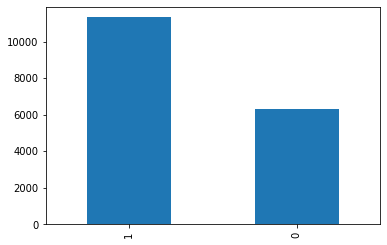

In [46]:
train_data['label'].value_counts().plot(kind = 'bar')

In [47]:
#전처리 함수 만들기
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
  #함수인자설명
  # review: 전처리할 텍스트
  # okt: okt객체를 반복적으로 생성하지 않고 미리 생성 후 인자로 받음
  # remove_stopword: 불용어를 제거할지 여부 선택. 기본값 False
  # stop_words: 불용어 사전은 사용자가 직접 입력, 기본값 빈 리스트

  # 1. 한글 및 공백 제외한 문자 모두 제거
  review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)
  
  #2. okt 객체를 활용하여 형태소 단어로 나눔
  word_review = okt.morphs(review_text,stem=True)

  if remove_stopwords:
    #3. 불용어 제거(선택)
    word_review = [token for token in word_review if not token in stop_words]
  return word_review

In [48]:
# 전체 텍스트 전처리
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한','카뱅','도']
okt = Okt()
clean_train_review = []

for review in train_data['content']:
  # 리뷰가 문자열인 경우만 전처리 진행
  if type(review) == str:
    clean_train_review.append(preprocessing(review,okt,remove_stopwords=True,stop_words= stop_words))
  else:
    clean_train_review.append([]) #str이 아닌 행은 빈칸으로 놔두기

clean_train_review[:4]

[['입출금',
  '통장',
  '만들다',
  '때',
  '인증',
  '방법',
  '을',
  '바꾸다',
  '하다',
  '이전',
  '으로',
  '가다',
  '버튼',
  '없다',
  '처음',
  '부터',
  '다시',
  '만들다',
  '하다',
  '이미',
  '계좌',
  '개설',
  '진행',
  '중이',
  '라서',
  '다시',
  '들어가다',
  '셀카',
  '인증',
  '으로',
  '돼다',
  '다시',
  '만들다',
  '일',
  '기다리다',
  '하다',
  '빼다',
  '다',
  '좋다',
  '선택',
  '수정',
  '게',
  '끄다',
  '해주다',
  '하다'],
 ['자꾸',
  '핸드폰',
  '인증',
  '라고',
  '반복',
  '되다',
  '그때',
  '마다',
  '매번',
  '인증',
  '하다',
  '하다',
  '번거롭다',
  '기도',
  '하고',
  '너무',
  '짜증나다',
  '앱',
  '을',
  '새롭다',
  '깔다',
  '안내',
  '를',
  '받다',
  '새롭다',
  '깔다',
  '마찬가지',
  '이고',
  '왜',
  '갑자기',
  '이렇다',
  '현상',
  '계속',
  '되다',
  '기술',
  '팀',
  '에서',
  '조속',
  '히',
  '해결',
  '해주다',
  '바라다',
  '핸드폰',
  '몇',
  '년',
  '계속',
  '사용',
  '하고',
  '있다',
  '기',
  '기',
  '변경',
  '라는',
  '게',
  '납득',
  '안되다'],
 ['전체',
  '적',
  '으로',
  '편리하다',
  '좋다',
  '이용',
  '하다',
  '줄',
  '만',
  '안다',
  '대체로',
  '스스로',
  '웬만하다',
  '건',
  '처리',
  '하다',
  '있다',
  '하다',
  '무엇',
  '보다',
  '스마트',
  '출금',
  

In [49]:
type(clean_train_review)

list

In [50]:
#테스트 리뷰도 동일하게 전처리
clean_test_review = []
for review in test_data['content']:
  if type(review) == str:
    clean_test_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
  else:
    clean_test_review.append([])

In [51]:
# 인덱스 벡터 변환 후 일정 길이 넘어가거나 모자라는 리뷰 패딩처리
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index #단어사전형태
MAX_SEQUENCE_LENGTH = 8 #문장 최대 길이

#학습 데이터
train_inputs = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH,padding='post')

#학습 데이터 라벨 벡터화
train_labels = np.array(train_data['label'])

#평가 데이터 
test_inputs = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH,padding='post')
#평가 데이터 라벨 벡터화
test_labels = np.array(test_data['label'])

In [52]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 8377
등장 빈도가 2번 이하인 희귀 단어의 수: 4916
단어 집합에서 희귀 단어의 비율: 58.684493255342005
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4515907009550464
단어 집합의 크기 : 3463


In [53]:
from base64 import encode
import encodings


DEFAULT_PATH  = './data/sample_data/'
DATA_PATH = 'clean_data/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs={}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) + 1

#전처리한 데이터들 파일로저장
if not os.path.exists(DEFAULT_PATH + DATA_PATH):
  os.makedirs(DEFAULT_PATH+DATA_PATH)

#전처리 학습데이터 넘파이로 저장
np.save(open(DEFAULT_PATH+DATA_PATH+TRAIN_INPUT_DATA,'wb'),train_inputs)
np.save(open(DEFAULT_PATH+DATA_PATH+TRAIN_LABEL_DATA,'wb'),train_labels)
#전처리 테스트데이터 넘파이로 저장
np.save(open(DEFAULT_PATH+DATA_PATH+TEST_INPUT_DATA,'wb'),test_inputs)
np.save(open(DEFAULT_PATH+DATA_PATH+TEST_LABEL_DATA,'wb'),test_labels)

In [54]:
# 학습 데이터 불러오기
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

In [55]:
#전처리 데이터 불러오기
DATA_PATH = './data/sample_data/clean_data/'
DATA_OUT = './data/sample_data/out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_PATH + INPUT_TRAIN_DATA,'rb'))
train_input = pad_sequences(train_input,maxlen=train_input.shape[1])
train_label = np.load(open(DATA_PATH + LABEL_TRAIN_DATA,'rb'))
prepro_configs = data_configs

In [56]:
model_name= 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs={'model_name': model_name, 'vocab_size':prepro_configs['vocab_size'],'embbeding_size':128, 'num_filters':100,'dropout_rate':0.5, 'hidden_dimension':250,'output_dimension':1}

In [57]:
class CNNClassifier(tf.keras.Model):

  def __init__(self, **kargs):
    super(CNNClassifier, self).__init__(name=kargs['model_name'])
    self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embbeding_size'])
    self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], kernel_size=kernel_size, padding='valid',activation = tf.keras.activations.relu,
                                    kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3)) for kernel_size in [3,4,5]]
    self.pooling = layers.GlobalMaxPooling1D()
    self.dropout = layers.Dropout(kargs['dropout_rate'])
    self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                            activation = tf.keras.activations.relu,
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    self.fc2 = layers.Dense(units=kargs['output_dimension'],
                            activation=tf.keras.activations.sigmoid,
                            kernel_constraint= tf.keras.constraints.MaxNorm(max_value=3.))
    

  def call(self,x):
    x = self.embedding(x)
    x = self.dropout(x)
    x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = 1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x


In [58]:
from tensorflow.keras.models import save_model

In [59]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])

#검증 정확도를 통한 EarlyStopping 기능 및 모델 저장 방식 지정
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = DATA_OUT + model_name +'\weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor = 'val_accuracy', verbose=1, save_best_only = True,
    save_weights_only=True
)

history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

# 모델 저장하기
save_model(model,'./data/sample_data/my_models/')

./data/sample_data/out/cnn_classifier_kr -- Folder already exists 

Epoch 1/10
31/32 [============================>.] - ETA: 0s - loss: 0.4861 - accuracy: 0.7472
Epoch 1: val_accuracy improved from -inf to 0.80510, saving model to ./data/sample_data/out/cnn_classifier_kr\weights.h5
32/32 [==============================] - 2s 49ms/step - loss: 0.4862 - accuracy: 0.7472 - val_loss: 0.4287 - val_accuracy: 0.8051
Epoch 2/10
31/32 [============================>.] - ETA: 0s - loss: 0.2854 - accuracy: 0.8899
Epoch 2: val_accuracy improved from 0.80510 to 0.87932, saving model to ./data/sample_data/out/cnn_classifier_kr\weights.h5
32/32 [==============================] - 1s 35ms/step - loss: 0.2854 - accuracy: 0.8899 - val_loss: 0.2754 - val_accuracy: 0.8793
Epoch 3/10
30/32 [===========================>..] - ETA: 0s - loss: 0.2265 - accuracy: 0.9154
Epoch 3: val_accuracy improved from 0.87932 to 0.89122, saving model to ./data/sample_data/out/cnn_classifier_kr\weights.h5
32/32 [==============

INFO:tensorflow:Assets written to: ./data/sample_data/my_models/assets


INFO:tensorflow:Assets written to: ./data/sample_data/my_models/assets


In [60]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_PATH+INPUT_TEST_DATA,'rb'))
test_input = pad_sequences(test_input,maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_PATH + LABEL_TEST_DATA, 'rb'))

In [61]:
model.load_weights('./data/sample_data/out/cnn_classifier_kr\weights.h5')
model.evaluate(test_input, test_label_data)

552/552 [==============================] - 1s 1ms/step - loss: 0.1541 - accuracy: 0.9503


[0.15410929918289185, 0.9502947330474854]

In [62]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
okt = Okt()
tokenizer  = Tokenizer()

DATA_CONFIGS = 'data_configs.json'
prepro_configs = data_configs
prepro_configs['vocab'] = word_vocab

tokenizer.fit_on_texts(word_vocab)

In [63]:
def sentiment_predict(sentence):
    MAX_LENGTH = 8 #문장최대길이
    
    sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\\s ]','', sentence)
    stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한','카뱅','도'] # 불용어 추가할 것이 있으면 이곳에 추가
    sentence = okt.morphs(sentence, stem=True) # 토큰화
    sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
    vector  = tokenizer.texts_to_sequences(sentence)
    pad_new = pad_sequences(vector, maxlen = MAX_LENGTH) # 패딩
    #print('변환된 문자 결과값: ',pad_new)
    model.load_weights('./data/sample_data/out/cnn_classifier_kr\weights.h5') #모델 불러오기
    predictions = model.predict(pad_new)
    predictions = float(predictions.squeeze(-1)[1])
    #print(predictions)
    if(predictions > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(predictions * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - predictions) * 100))

In [67]:
sentiment_predict('이체하기 편하고 쉬워서 좋아요ㅎㅎ')

1/1 [==============================] - 0s 11ms/step
78.21% 확률로 긍정 리뷰입니다.

